# Proyecto ML

## Wikipedia Movie Plots

Importa las librarías que se usaran

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk import word_tokenize, download
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

plt.style.use('ggplot')

Carga los datos (se pueden bajar de aquí: https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

In [2]:
df = pd.read_csv("wiki_movie_plots_deduped.csv")
df.rename(columns={'Origin/Ethnicity':'Origin'}, inplace=True) # para mayor comodidad
df.shape

(34886, 8)

Muestra de los primeros datos

In [3]:
df.head(3)

,Release Year,Title,Origin,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."


### Descripción de las columnas

La base de datos contiene descripciones para 34,886 películas de todo el mundo. las columnas son las siguientes:

- Release Year - Año en que se estreno la película
- Title - Titulo de la película
- Origin/Ethnicity - Origen de la pelicula (e.g. America, Bollywood, Tamil, etc)
- Director - Director(s)
- Cast - Actores y actrices principales
- Genre - Genero(s) de la película
- Wiki Page - URL de la pagina de Wikipedia de la cual la descripción de la trama fue tomada
- Plot - descripción larga de la trama de la película (ADVERTENCIA: puede contener espoilers)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
Release Year    34886 non-null int64
Title           34886 non-null object
Origin          34886 non-null object
Director        34886 non-null object
Cast            33464 non-null object
Genre           34886 non-null object
Wiki Page       34886 non-null object
Plot            34886 non-null object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [5]:
df.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


## Graficas

### Países de origen de las pelícuals

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

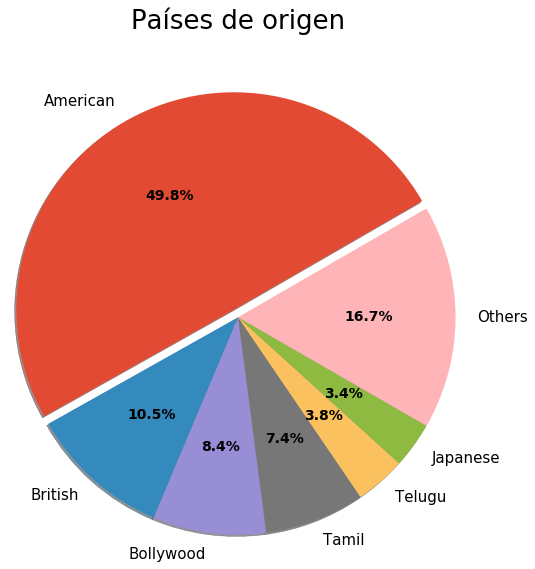

In [6]:
fig, ax = plt.subplots()
_, texts, autotexts = ax.pie(list(df['Origin'].value_counts()[:6].values) + [sum(df['Origin'].value_counts()[6:])], 
                    explode=(0.1, 0, 0, 0, 0, 0, 0), 
                    labels=list(df['Origin'].value_counts()[:6].index) + ["Others"], 
                    autopct='%1.1f%%',
                    shadow=True, radius=2.5, 
                    startangle=30)

ax.set_title('Países de origen', fontsize=26, loc="center",  y=1.8)
plt.setp(texts, size=15)
plt.setp(autotexts, size=14, weight="bold")

### Número de películas por año

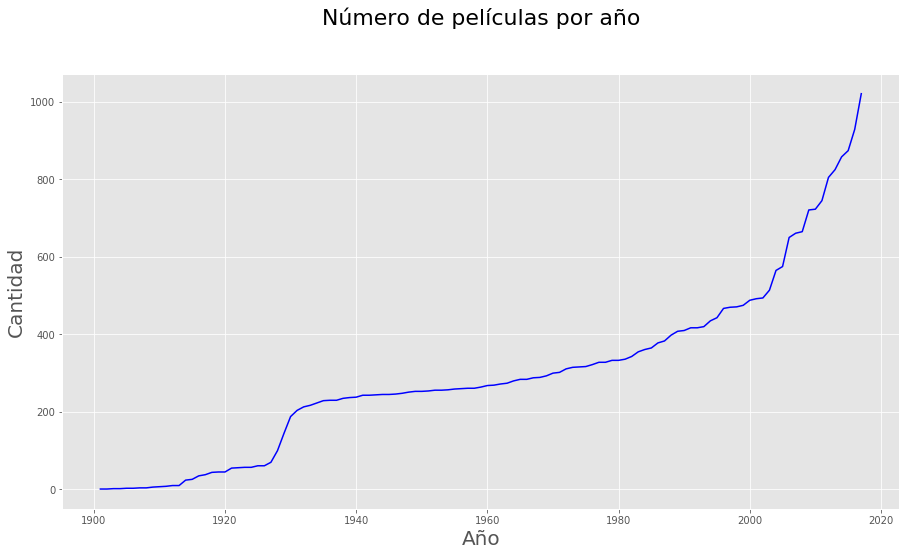

In [7]:
plt.figure(figsize=(15,8))
plt.title('Número de películas por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Cantidad', fontsize=20)
ax = plt.plot(df['Release Year'].unique()[::-1], df['Release Year'].value_counts(), 'b-')

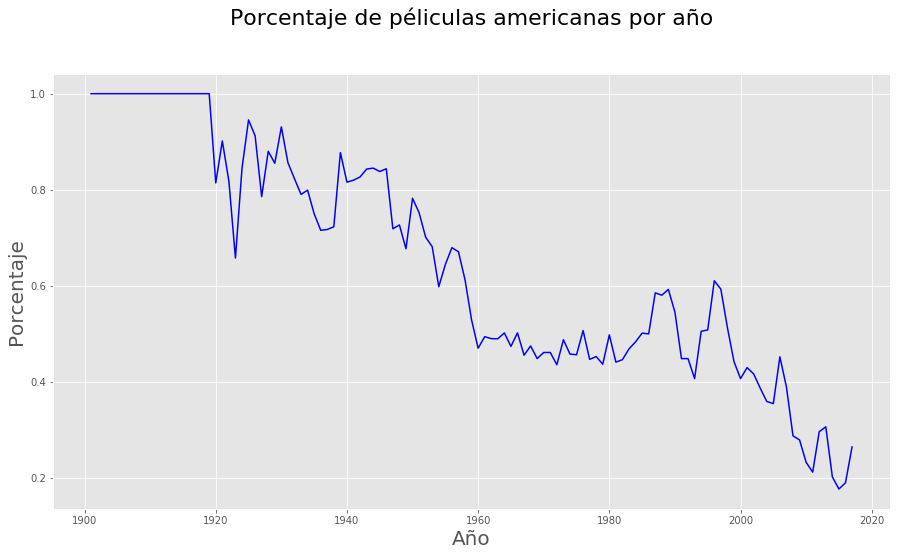

In [8]:
american_movies = df.query('Origin == "American"')['Release Year'].value_counts()
anywhere_movies = df['Release Year'].value_counts()

percentages = american_movies.divide(anywhere_movies)

plt.figure(figsize=(15,8))
plt.title('Porcentaje de péliculas americanas por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Porcentaje', fontsize=20)
ax = plt.plot(df['Release Year'].unique()[::-1], percentages[::-1], 'b-')

Géneros

In [9]:
len(df['Genre'].unique())

2265

### Reducción del numero de géneros

In [10]:
#df['Genre'].value_counts().head(50)
df['GenreCorrected'] = df['Genre']
df['GenreCorrected'] = df['GenreCorrected'].str.replace('sci-fi', 'science fiction')
#df['GenreCorrected'] = df['GenreCorrected'].apply(lambda x: re.sub(r',.*', r'', x))
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r',.*', r'')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'-.*', r'')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r' /.*', r'')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'/.*', r'')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'[.*]', r'')
# Eliminacion de generos multiples y subgénreos
#df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'comedy drama', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'melodrama', r'drama')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'dramedy', r'drama')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'family drama', r'drama')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'costume drama', r'drama')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'spy drama', r'drama')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'social satire drama', r'drama')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'literary drama', r'drama')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'prison drama', r'drama')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'animation drama', r'drama')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'drama family', r'family')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'war drama', r'war')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'cold war', r'war')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'world war ii', r'war')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'world war i', r'war')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'war propaganda', r'war')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'romantic', r'romance')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'rom', r'romance')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'sports drama', r'sports')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'silent sports', r'sports')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'comedy short', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'black comedy', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'dark comedy', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'teen comedy', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'comedy comedy', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'animation comedy', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'short', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'screwball comedy', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'slapstick', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'comedy subject', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'spy comedy', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'satirical comedy', r'comedy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'sports comedy', r'comedy')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'rom com', r'romance comedy')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'historical drama', r'historical')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'history', r'historical')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'short mistery', r'mistery')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'animated', r'animation')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'animation short', r'animation')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'animation feature', r'animation')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'nfb animation', r'animation')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'animation co', r'animation')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'anime for children', r'animation')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'anime', r'animation')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'national  board animation', r'animation')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'science fiction comedy', r'science fiction')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'^bio$', r'biographical')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'western comedy', r'western')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'comedy western', r'western')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'film', r'')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'children\'s', r'children')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'social drama', r'social')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'socio', r'social')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'african adventure', r'adventure')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'animation adventure', r'adventure')

df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'^j$', r'unknown')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'biopic', r'biography')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'slasher', r'horror')


df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'kung fu', r'martial arts')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'spy thriller', r'thriller')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'animation fantasy', r'fantasy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'fantasy animation', r'fantasy')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'heist', r'crime')
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'national  board documentary', r'documentary')

df['GenreCorrected'] = df['GenreCorrected'].str.strip()
df['GenreCorrected'] = df['GenreCorrected'].str.replace(r'^$', r'unknown')
print(df['GenreCorrected'].value_counts()[150:200])

western drama                 3
biography drama               3
musical fantasy               3
thriller romanceance          3
musical biography             3
ravi teja                     3
romanceance fantasy           3
educational                   3
romanceance social            3
superhero action adventure    3
adventure drama               3
srikanth                      3
costume action                3
comedy action                 3
pow                           2
christian drama               2
zombie horror                 2
pawan kalyan                  2
boxing drama                  2
social satire                 2
imdb                          2
jidaigeki                     2
fiction                       2
science fiction mystery       2
blaxploitation                2
mob                           2
war romanceance               2
sports (shogi                 2
detective fiction             2
teen romanceance              2
supernatural comedy           2
comedy f

Text(0, 0.5, 'Número de ocurrencias')

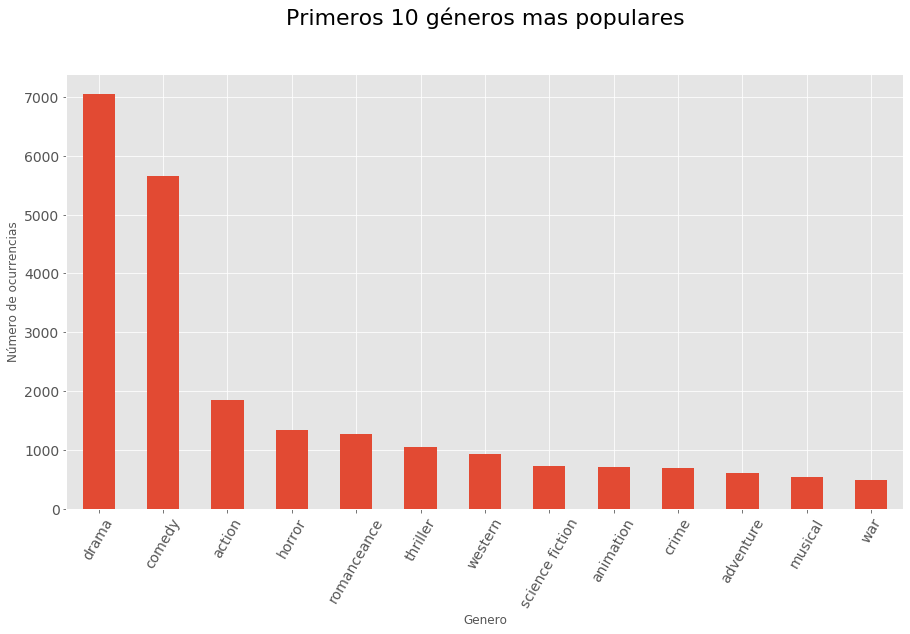

In [11]:
GenreCorrected = df.query('GenreCorrected != "unknown"')['GenreCorrected'].value_counts()
ax = GenreCorrected[:13].plot(kind='bar', figsize=(15,8), fontsize=14)
ax.set_title('Primeros 10 géneros mas populares', size=22, y=1.1)
plt.xticks(rotation=60)
plt.xlabel('Genero')
plt.ylabel('Número de ocurrencias')

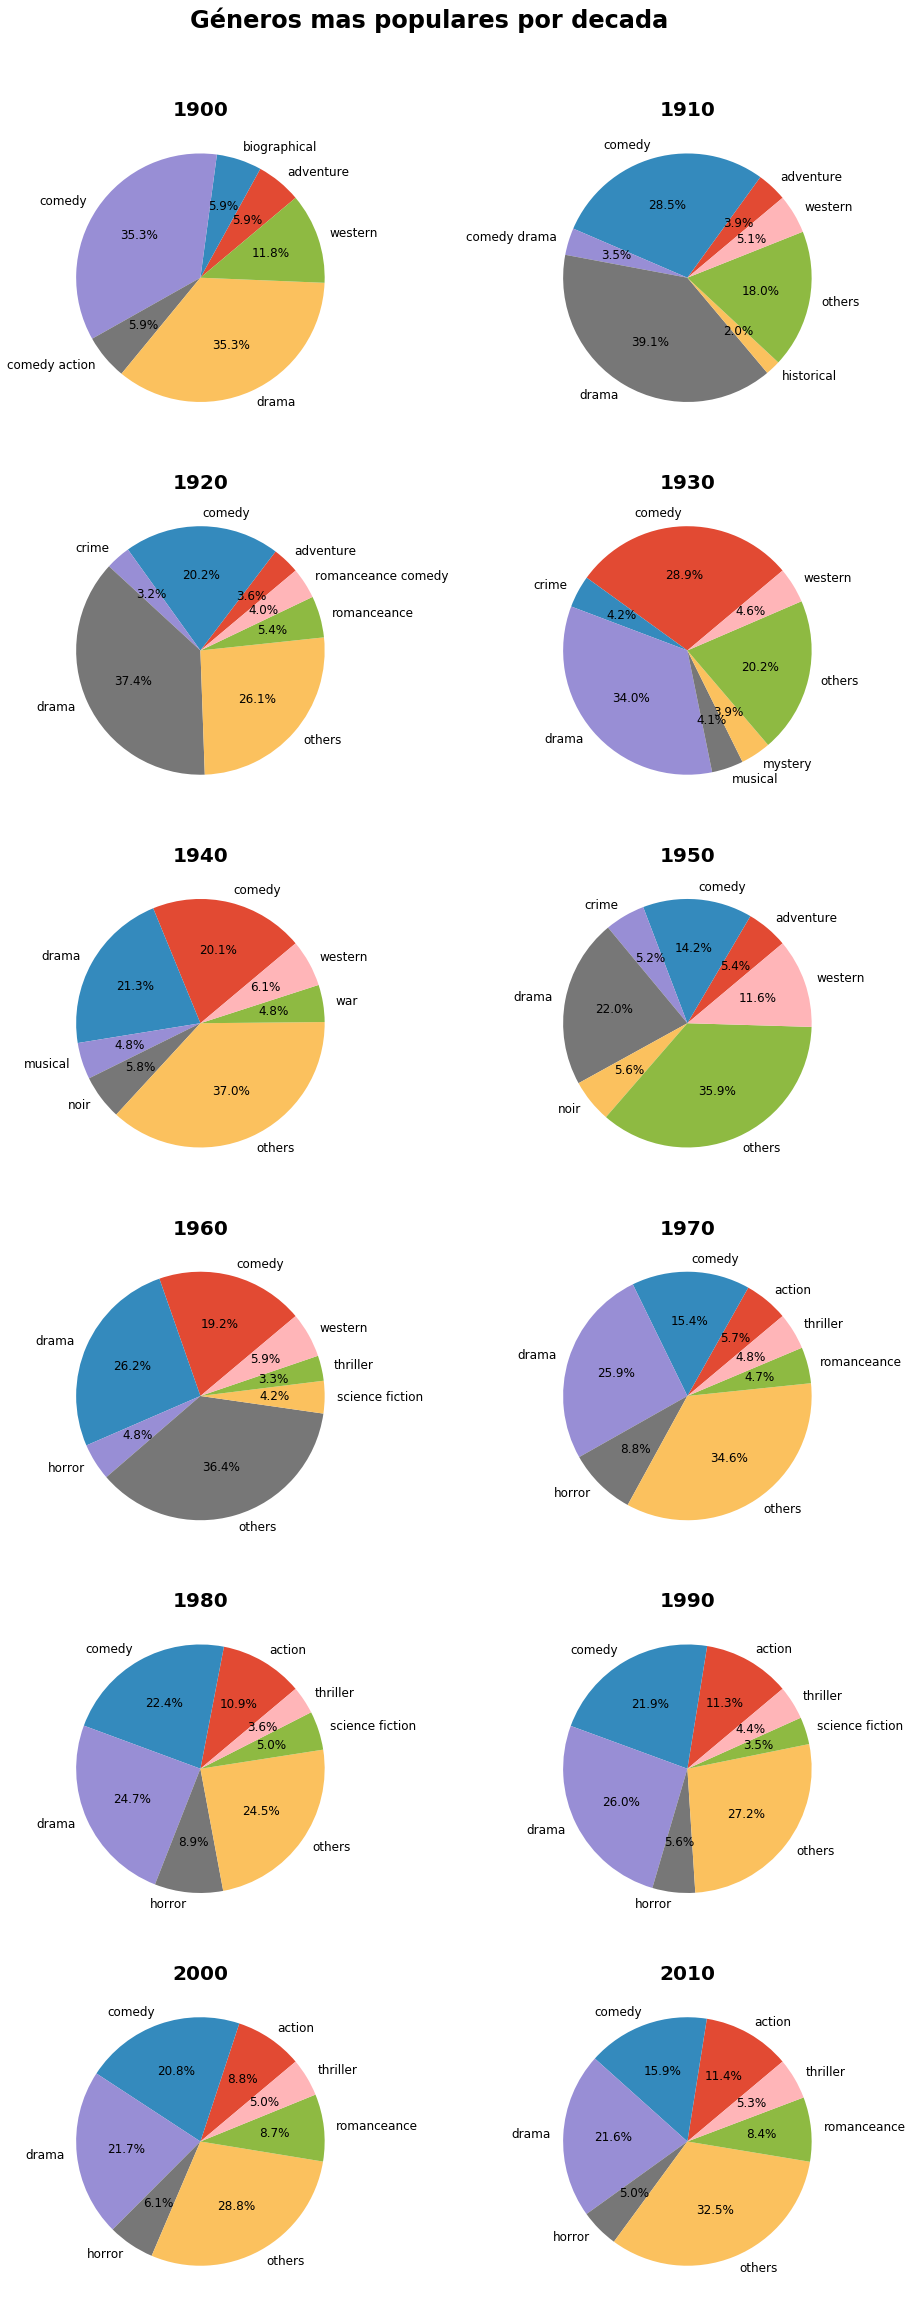

In [12]:
def grouping_func(s, index, splt_index):
    if list(s.index).index(index) > splt_index:
        return 'others'
    return index

fig, axes = plt.subplots(nrows=6, ncols=2)
fig.suptitle("Géneros mas populares por decada", fontsize=24, y=0.92, weight="bold")

for i, decade in enumerate(range(1900,2017,10)):
    populars = df.query(f'`Release Year` >= {decade} & `Release Year` < {decade+10} & GenreCorrected != "unknown"')['GenreCorrected'].value_counts()
    populars.groupby(lambda s: grouping_func(populars, s, 5)).sum().plot(ax=axes[i//2,i%2], 
                                                                         kind='pie', 
                                                                         fontsize=12, 
                                                                         autopct='%1.1f%%', 
                                                                         figsize=(16,40), 
                                                                         startangle=40, 
                                                                         label="")
    axes[i//2,i%2].set_title(f"{decade}", fontsize=20, weight="bold")

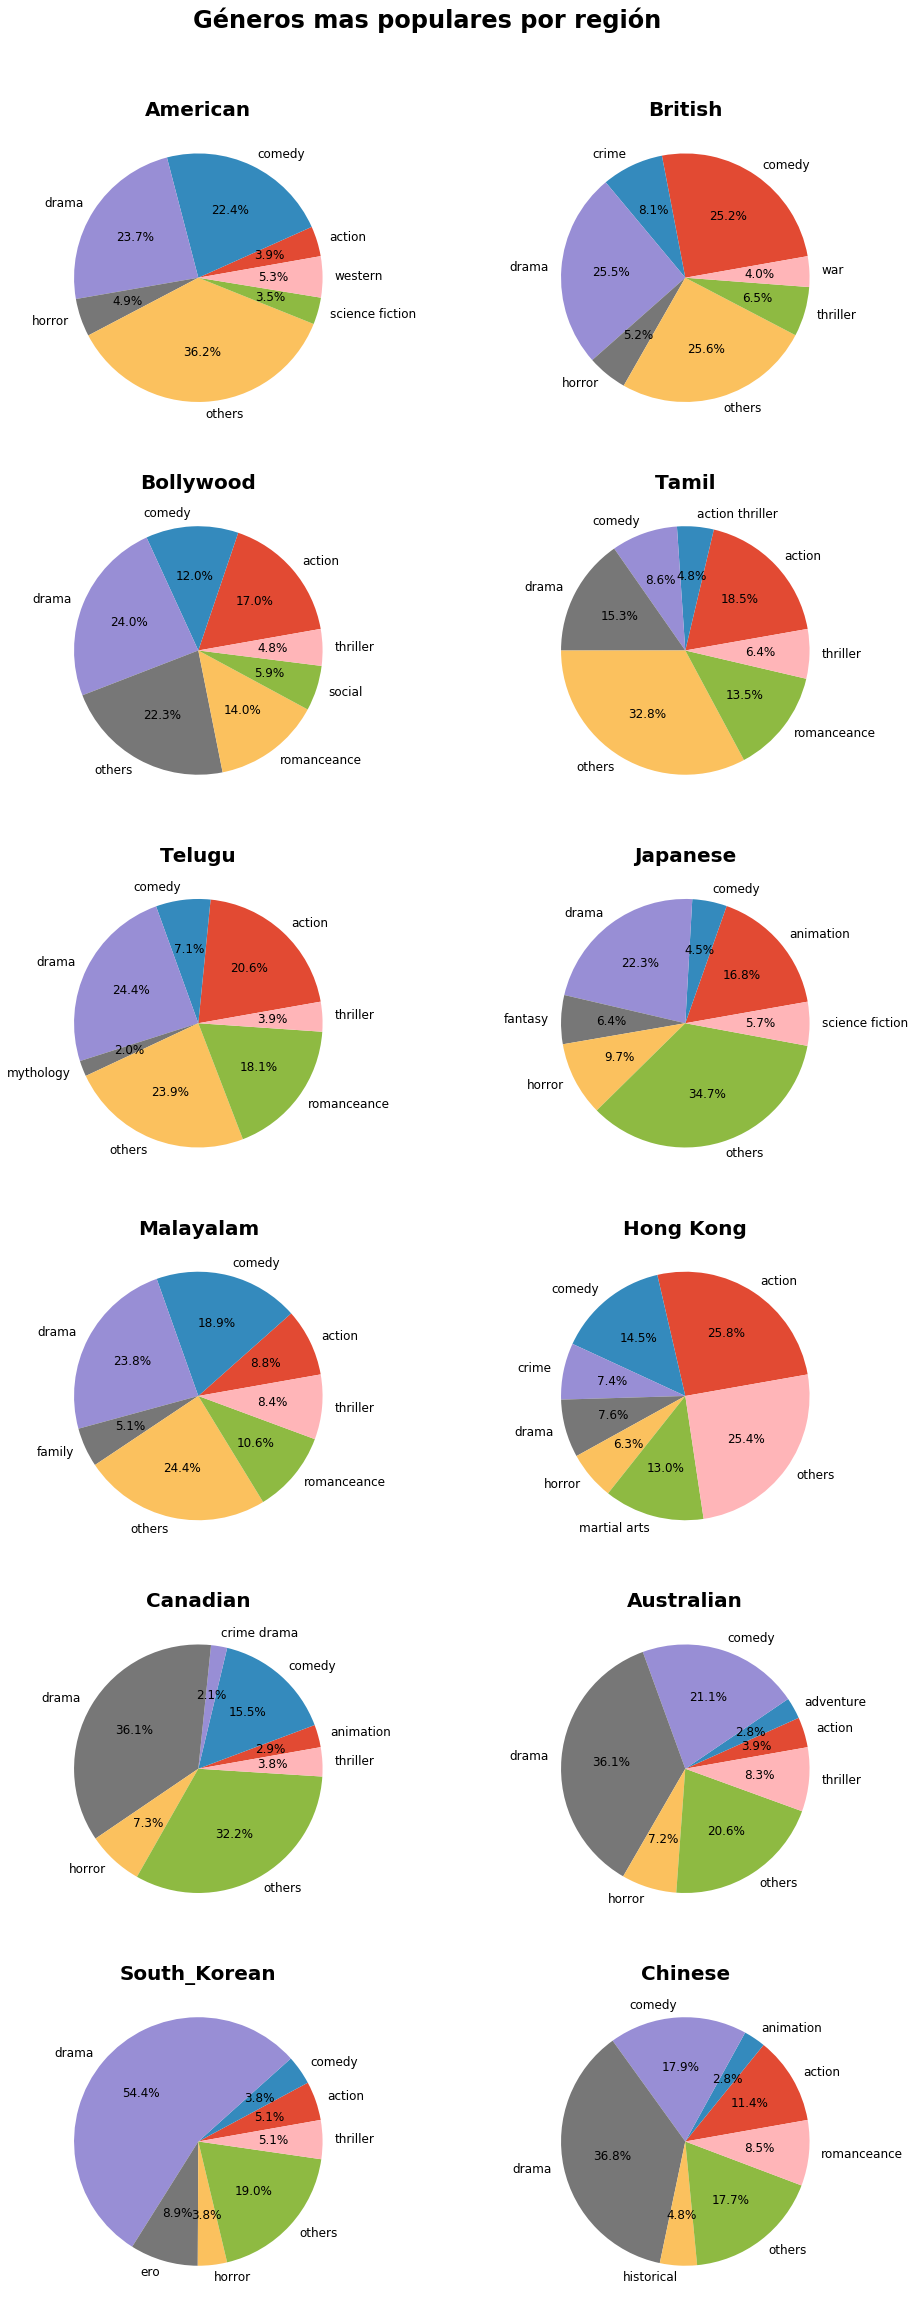

In [13]:
def grouping_func(s, index, splt_index):
    if list(s.index).index(index) > splt_index:
        return 'others'
    return index

fig, axes = plt.subplots(nrows=6, ncols=2)
fig.suptitle("Géneros mas populares por región", fontsize=24, y=0.92, weight="bold")

for i, origin in enumerate(df['Origin'].value_counts().head(12).index):
    populars = df.query(f'(Origin == "{origin}") & (GenreCorrected != "unknown")')['GenreCorrected'].value_counts()
    populars.groupby(lambda s: grouping_func(populars, s, 5)).sum().plot(ax=axes[i//2,i%2], kind='pie', 
                                                                         fontsize=12, autopct='%1.1f%%', 
                                                                         figsize=(16,40), startangle=10, 
                                                                         label="")
    axes[i//2,i%2].set_title(f"{origin}", fontsize=20, weight="bold")

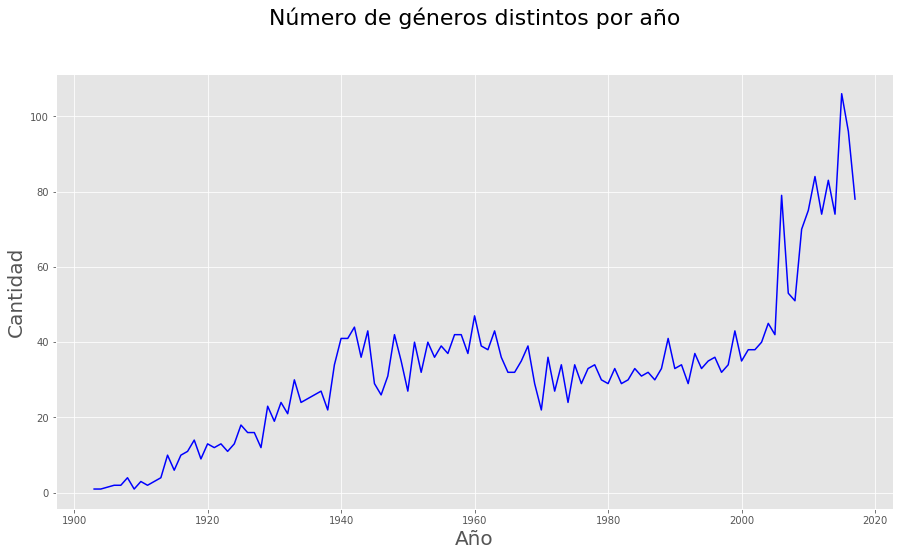

In [14]:
print()
plt.figure(figsize=(15,8))
plt.title('Número de géneros distintos por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Cantidad', fontsize=20)
genres_per_year = df.query('Genre != "unknown"').groupby('Release Year')['GenreCorrected'].nunique()
ax = plt.plot(genres_per_year.index,
              genres_per_year, 'b-')

### Algunos ejemplos de tramas

In [15]:
print(f'{df["Title"][342]} - {df["Release Year"][342]}')
print("")
print(df['Plot'][342])

Old Lady 31 - 1920

Based upon a summary of the plot in a review in a film publication,[3] Angie (Dunn) and Abe (Harmon) have been married for many years when bad investments force them to sell their homestead. Angie is to go to the old ladies' home while Abe is to go to live on the poor farm. When the twenty-nine inmates of the old ladies' home see how hard it is for the couple to part, they agree to take Abe in, and he is listed on their roster as "Old Lady 31." There are several comic situations as Abe wins his way into the hearts of his female companions. When some apparently worthless mining stock is found to have some value, the couple are able to return to their home.


In [16]:
print("{} - {}".format(df['Title'][7347],df['Release Year'][7347]))
print("")
print(df['Plot'][7347])

Five Guns to Tombstone - 1960

Young outlaw Billy Wade, determined to reform, is roped into a robbery by rich businessman George Landon, then framed for it. Billy's brother Matt is sprung from prison by Landon on the condition he get Billy to go along with the theft. During a struggle for a gun, Matt is accidentally killed and his teenaged son Ted and others mistakenly believe Billy killed him in cold blood. Billy pretends to help bandit Ike Garvey but ultimately assists in his capture, earning Ted's forgiveness.


In [17]:
print("{} - {}".format(df['Title'][5],df['Release Year'][5]))
print("")
print(df['Plot'][5])

Alice in Wonderland - 1903

Alice follows a large white rabbit down a "Rabbit-hole". She finds a tiny door. When she finds a bottle labeled "Drink me", she does, and shrinks, but not enough to pass through the door. She then eats something labeled "Eat me" and grows larger. She finds a fan when enables her to shrink enough to get into the "Garden" and try to get a "Dog" to play with her. She enters the "White Rabbit's tiny House," but suddenly resumes her normal size. In order to get out, she has to use the "magic fan."
She enters a kitchen, in which there is a cook and a woman holding a baby. She persuades the woman to give her the child and takes the infant outside after the cook starts throwing things around. The baby then turns into a pig and squirms out of her grip. "The Duchess's Cheshire Cat" appears and disappears a couple of times to Alice and directs her to the Mad Hatter's "Mad Tea-Party." After a while, she leaves.
The Queen invites Alice to join the "ROYAL PROCESSION": a p

### Formato de los textos

In [18]:
print("{} - {}".format(df['Title'][2454],df['Release Year'][2454]))
print("")
text = df['Plot'][2454]
text

The Sisters - 1938



"At a ball held on the night of the 1904 presidential election, serious Louise, frivolous Helen, and stolid Grace, daughters of Silver Bow, Montana pharmacist Ned Elliott and his wife Rose, find themselves dealing with romantic prospects. Tom Knivel is about to propose to Louise when Frank Medlin, a San Francisco sports reporter, asks her to dance. Infatuated with the young woman, Frank extends his stay, and at Sunday dinner in the Elliott home he announces he and Louise plan to wed. Although her parents disapprove of the union, Louise leaves for San Francisco with Frank that night. Grace eventually marries the jilted Tom and Helen weds wealthy Sam Johnson, who promises her freedom and asks for nothing in return.\r\nAlthough facing financial difficulty, Louise urges Frank to complete his novel. When she becomes pregnant, she decides to keep her condition a secret, but finally reveals the truth when she accompanies Frank to a boxing match and the smoke and smells make her ill. Returning

In [19]:
def clean_text(text):
    """
    This function is taken from:
    https://www.kaggle.com/aminejallouli/genre-classification-based-on-wiki-movies-plots
    """
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\[\d+\]", "", text)
    text = re.sub(r"[\(\)\"\r\[\]\{\}\\/¿\?\¡\!:,\.\']", "", text)
    text = re.sub(r"[-\n]", " ", text)
    text = text.strip(' ')
    return text

# test
print(clean_text(df['Plot'][2454]))

at a ball held on the night of the 1904 presidential election serious louise frivolous helen and stolid grace daughters of silver bow montana pharmacist ned elliott and his wife rose find themselves dealing with romantic prospects tom knivel is about to propose to louise when frank medlin a san francisco sports reporter asks her to dance infatuated with the young woman frank extends his stay and at sunday dinner in the elliott home he announces he and louise plan to wed although her parents disapprove of the union louise leaves for san francisco with frank that night grace eventually marries the jilted tom and helen weds wealthy sam johnson who promises her freedom and asks for nothing in return although facing financial difficulty louise urges frank to complete his novel when she becomes pregnant she decides to keep her condition a secret but finally reveals the truth when she accompanies frank to a boxing match and the smoke and smells make her ill returning home louise suffers a mis

In [20]:
df['FormattedPlot'] = df['Plot'].apply(clean_text)

### Nubes de palabras

Nube de palabras de las tramas en general

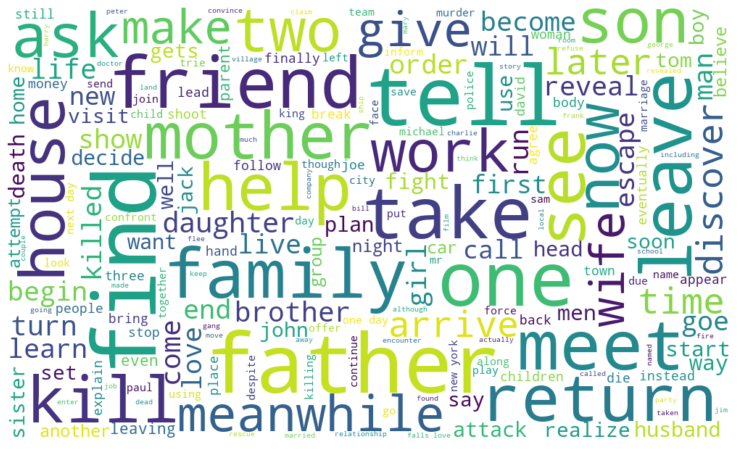

In [21]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      width=1000, 
                      height=600, 
                      max_font_size=120,
                      background_color="white").generate(" ".join(df.FormattedPlot))

plt.subplots(figsize=(18,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Nube de palabras de las tramas por genero

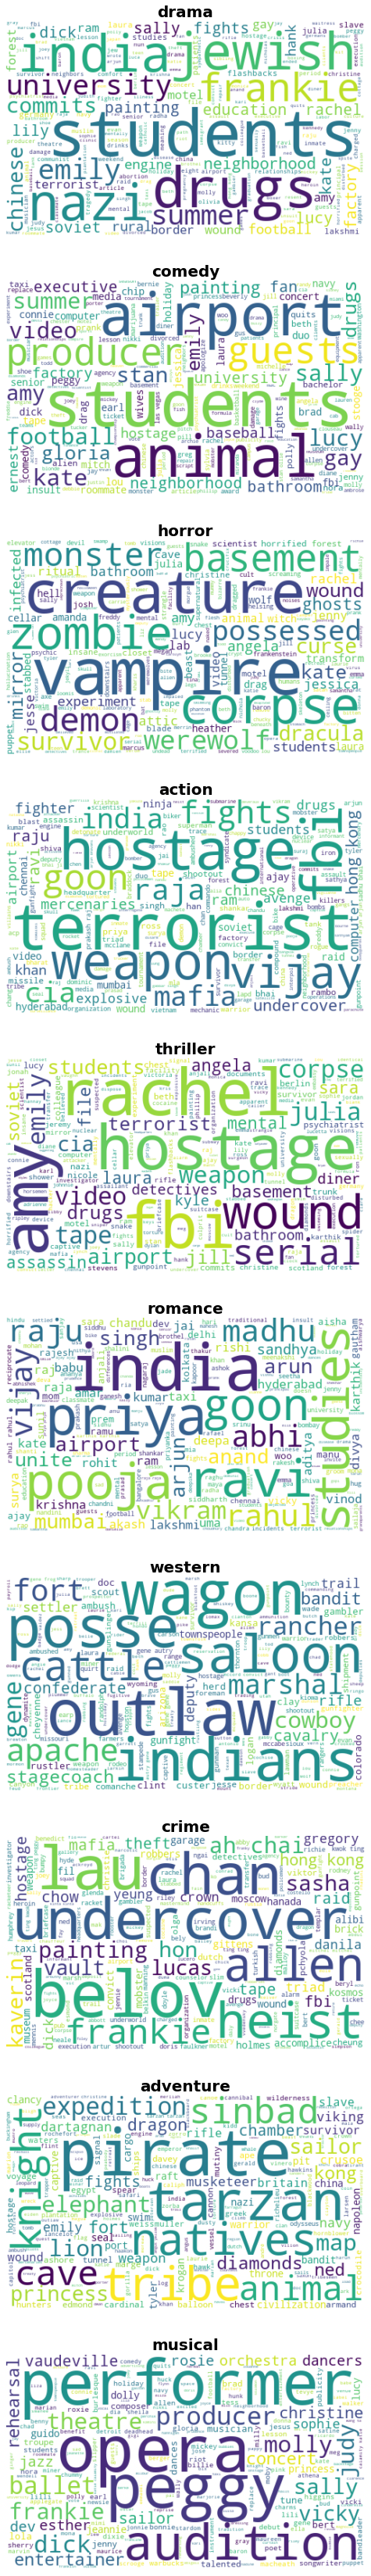

In [22]:
stopwords = set(STOPWORDS)
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(20,60))
#stopwords.update(['father', 'find', 'tell', 'meet', 'one', 'two', 'later', 'goes', 'take', 'finds', 'leave'])

frequent_words = dict()

for i, genre in enumerate(df['Genre'].value_counts()[1:11].index):
    words = list(set(word_tokenize(" ".join(df.query(f'Genre == "{genre}"')['FormattedPlot']))))
    for word in words:
        if word in frequent_words:
            frequent_words[word] += 1
        else:
            frequent_words[word] = 1
    
ordered_words = []
for key, value in frequent_words.items():
    ordered_words.append((value, key))
    
for word in ordered_words:
    if word[0] > 9:
        stopwords.add(word[1])

for i, genre in enumerate(df['Genre'].value_counts()[1:11].index):
    wordcloud = WordCloud(stopwords=stopwords,
                          width=500, 
                          height=300, 
                          max_font_size=90,
                          background_color="white").generate(" ".join(df.query(f'Genre == "{genre}"')['FormattedPlot']))
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title("{}".format(genre), fontsize=20, weight="bold")
    axes[i].axis('off')

## Entrenando un clasificador (la parte divertida)

In [23]:
data = df.query('GenreCorrected != "unknown"')
clases = list(data['GenreCorrected'].value_counts().head(140).index)

data = data[data.GenreCorrected.isin(clases)]
data = data.reset_index()

X_train, X_test, y_train, y_test = train_test_split(list(data['FormattedPlot']), 
                                                    list(data['GenreCorrected']), 
                                                    random_state=0)

stemmer = WordNetLemmatizer()
for i in range(len(X_train)):
    X_train[i] = [stemmer.lemmatize(word) for word in X_train[i].split(' ')]
    X_train[i] = ' '.join(X_train[i])
    
bag_of_words = CountVectorizer(max_features=1500, min_df=2, max_df=0.7, stop_words='english')
X_train = bag_of_words.fit_transform(X_train).toarray()

In [24]:
tfidfconverter = TfidfTransformer()
X_train = tfidfconverter.fit_transform(X_train).toarray()

In [25]:
clf = LinearSVC(random_state=0, max_iter=50000)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=50000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [26]:
for i in range(len(X_test)):
    X_test[i] = [stemmer.lemmatize(word) for word in X_test[i].split(' ')]
    X_test[i] = ' '.join(X_test[i])

X_test = bag_of_words.fit_transform(X_test).toarray()
X_test = tfidfconverter.fit_transform(X_test).toarray()

In [27]:
print(f'the mean error is {np.mean(cross_val_score(clf, X_test, y_test, cv=4))}')

/home/ricardo/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


the mean error is 0.3709888206325697


In [29]:
i = 1
print(clf.predict([X_test[i]])[0])
print(y_test[i])

romanceance
mystery
